# will wright from right to left in Hebrew like the text cell blow

video link : https://drive.google.com/file/d/1io6o5qJIuagpRiYOjBlARb9oGeGp3w-W/view?usp=drive_link

<div dir="rtl" style="font-weight: bold; font-size: 24px;">
ממן 14 - פז כהן
</div>
<div dir="rtl">
יבוא של סיפריות ופונקצית בדיקה שהקלטים לפונקציות בשאלות הבאות תקינות, בנוסף pyplot לגרפים
</div>

In [42]:
#import library's
import torch
from torchvision import transforms, datasets
import pandas as pd
import math
from torch import nn
from torch.nn import functional as func
from tqdm import tqdm
from matplotlib import pyplot as plt
from collections.abc import Iterable
from torch.utils.data import Dataset, DataLoader

<div dir="rtl" style="font-weight: bold; font-size: 24px;">
שאלה 1 סעיף א'+ב'
</div>
<div dir="rtl">
     נתחיל ביצור class עבור SplitLinear, בעלת בנאי ופונקציית forward </br>
     איתחול פרמטרים : <br>
     > כאמור השיכבה צריכה לקבל קלט ולהחזיר פלט ובכדי לדעת את גודל הקלט והפלט הרצואים הבנאי מבקש in_features, out_features <br>
     > הבנאי צריך לדעת מספר הפיצולים והתבקשנו לפצל לשני טנסורים ולכן מאותחל אוטומטית ל-2 <br>
     עבור המשקל בחרתי בשיטת Xavier אשר מוזכר בספר הקורס, Xavier שם משקלים בהיסטברות אחידה ומתחשב בגדלי הקלט והפלט. <br>
     היתרונות בבחירה זאת שבגלל ההתפלגות האחידה השיטה שוברת את הסימטריה שיש בהפעלת משקלים שווים לכול הראשת. <br>
     וכך עוזר להימנע ממספר נוירונים שונים בעלי אותו המשקל גם לאחר forward propagation ותוצאה בעלת הגראדיאנט שווה עבור מספר נוירונים. <br>
     בנוסף אני מאתחל את השיכבה הלינארית ושכבת ה ReLU, כאשר גודל השיכבה הלינארית מקבלת את מספר הצ'נקים הנכנסים ומוציאה את המספר הצ'נקים היוצאים. <br><br>
     ->אציין שבגלל סעיף ג' הייתי צריך להוסיף הדפסות אך בגלל שרציתי להשתמש ב SplitLinear בשאלה 2 ובכדי לחסוך בהרבה הדפסות מיותרות כלל ה print נמצאים בהערה 
</div>

In [47]:
'''
SplitLinear class : for a NN layer that split the input featues into chunks with the same size,
SplitLinear then apply Linear-ReLU layers and concatenates the result into output.

Methods :
    __init__ :  Initialize and Create the SplitLinear object for NN Layer.
        Input :
            > 'in_features' - number of input feature sample
            > 'out_features' - number of output feature sample
            > 'split_size' - number to equally split the input / output
            > 'bias' - learn with additive bias Ture/False

    forward : Forward Propagation on the SplitLinear Layer.
        Input :
            > 'input_tensor' - tensore shape of input features
        Reture : 
            > 'output' - tensore shape of output features
'''
class SplitLinear(nn.Module):
    def __init__(self,in_features, out_features, split_size = 2, bias=True) :
        super().__init__()
        
        #chatGPT help with the assert syntax
        #check the input and output dimensions are splitable without remainder
        assert in_features % split_size == 0 and out_features % split_size == 0, ('' +
               f'in_features ({in_features}) and out_features ({out_features}) of ' +
               f'a SplitLinear layer should be a multiplication of the split_to ' +
               f'({split_size}).')
        
        #initialize paraneters
        self.split_size = split_size
        self.in_features = in_features
        self.out_features = out_features
        self.in_chunk = int(in_features/split_size)
        self.out_chunk = int(out_features/split_size)

        #initialize the linear and ReLU layer.
        self.linear = nn.Linear(in_features=self.in_chunk,
                                out_features=self.out_chunk,
                                bias=bias)
        self.relu = nn.ReLU()
        
        #initialize the weight and apply the weight uniformly.
        weight = (6/(self.in_chunk + self.out_chunk)) ** 2
        nn.init.uniform_(self.linear.weight, -weight, weight)


    def forward(self, input_tensor) :
        #chatgpt for the assert syntax.
        #assert that the input tensor have right dimentions.
        assert input_tensor.shape[1] == self.in_features and len(input_tensor.shape) == 2, (
            f'Error: Expected input with {self.in_features} features and 2 dimensions, '
            f'but got input with shape {input_tensor.shape}')

        batch_size = input_tensor.shape[0]
        
        #split the input into chunks2
        in_chunks = torch.split(input_tensor, self.in_chunk, dim=1)
        #print(f'print in chunks : \n{in_chunks}')
        
        #concatenate the chunks along the batch dimension.
        in_stacked_chunks = torch.cat(in_chunks, dim=0)
        #print(f'print stacked chunks : \n{in_stacked_chunks}')
        
        #apply the linear layer on concatenate chunks.
        out_linear_chunks = self.linear(in_stacked_chunks)
        #print(f'print result of Linear layer : \n{out_linear_chunks}')
        
        #apply the ReLU layer on linear concatenate chunks.
        out_stacked_chunks = self.relu(out_linear_chunks)
        #print(f'print result of ReLU layer : \n{out_stacked_chunks}')
        
        #split the processed chunks along the batch dimension.
        out_chunks = torch.split(out_stacked_chunks, batch_size, dim=0)
        #print(f'print out chunks : \n{out_chunks}')
        
        #concatenate the processed chunks result along the feature dimension.
        output = torch.cat(out_chunks, dim=1)

        return output

<div dir="rtl" style="font-weight: bold; font-size: 24px;">
שאלה 1 סעיף ג'
</div>
<div dir="rtl">
 נתחיל באתחול השכבה שבנינו, ובאיתחול טנזור שנעביר בשיכבה. </br>
ניתן לראות את התוצאות של השלבים השונים של SplitLinear על הטנסור שהכנסנו לשכבה.
</div>

In [46]:
#initialize parameters and crate the SplitLinear layer.
in_features = 6
out_features = 4
layer = SplitLinear(in_features=in_features, out_features=out_features)

#create a ransom tensor
input_tensor = torch.randn(3, in_features)
print(f'input : \n{input_tensor}')

#apply SplitLinear on the tensor
output = layer.forward(input_tensor)
print(f'output result : \n{output}')

input : 
tensor([[-0.6298,  0.3989,  0.4654,  0.2466, -0.4902,  0.3801],
        [ 0.7954,  0.4070,  1.3628,  1.0805, -0.3885, -0.0949],
        [ 0.2364, -2.2142, -0.6851, -0.9476, -2.0147, -0.9044]])
print in chunks : 
(tensor([[-0.6298,  0.3989,  0.4654],
        [ 0.7954,  0.4070,  1.3628],
        [ 0.2364, -2.2142, -0.6851]]), tensor([[ 0.2466, -0.4902,  0.3801],
        [ 1.0805, -0.3885, -0.0949],
        [-0.9476, -2.0147, -0.9044]]))
print stacked chunks : 
tensor([[-0.6298,  0.3989,  0.4654],
        [ 0.7954,  0.4070,  1.3628],
        [ 0.2364, -2.2142, -0.6851],
        [ 0.2466, -0.4902,  0.3801],
        [ 1.0805, -0.3885, -0.0949],
        [-0.9476, -2.0147, -0.9044]])
print result of Linear layer : 
tensor([[ 0.3471,  1.5366],
        [-1.1878,  0.5813],
        [ 2.7392, -3.1056],
        [ 0.5438, -0.4500],
        [-0.3831, -1.0807],
        [ 3.7176, -1.9100]], grad_fn=<AddmmBackward0>)
print result of ReLU layer : 
tensor([[0.3471, 1.5366],
        [0.0000, 0.581

<div dir="rtl" style="font-weight: bold; font-size: 24px;">
שאלה 1 סעיף ד'-ז'
</div>
<div dir="rtl">
התשובות לשאלה 1 סעיפים ד' עד ז' נימצאות בקובץ PDF המצורף ב zip
</div>

<div dir="rtl" style="font-weight: bold; font-size: 24px;">
שאלה 2 סעיפים א'-ג'
</div>
<div dir="rtl">
נתחיל ביצור class עבור DropNorm, בעלת בנאי ופונקציית forward. </br>
איתחול פרמטרים :<br>
>צורת הקלט אשר מכילה את גודל הקלט. <br>
>מספר בין 0 ל 1 (לא כולל 0 ו 1) אשר מייצק כמה אחוז מהיונרונים אנו רוצים לזרוק (drop). <br>
>אפסילון מספר ממשי קטן מעוד המשמש למכנה הנירמול. <br><br>
הפרמטרים הנוספים שיש לבחור הם הטנזורים gamma ו-beta אשר בחרתי לאתחל כטנסור של אחדים ו אפסים בהתאמה. <br>
הבחירה נובעל מיכך שבהתחלה אנני יודע איך לבחור את הקנה מידה שלפיו אני ארצה לעבוד במשוואה y=gamma * x_hat + beta. <br>
ולכן בחירה טבעית ואינטואיטיבית היא בהתחלה לא לשנות כלל את הקלט batch ובתהליך הלמידה לשנות את gamma ו beta בהתאם לקנה המידה הנילמד. <br>
כלומר נתחיל במשוואה y = x_hat וממנה נלמד.
</div>

In [48]:
'''
DropNorm class : a NN layer that first choos randomly certain features to drop acording to constant probability.
                 second normalize the feater that didn't droped out (useing the mean and variance).
                 and last rescales the features (with the learned parameters)
Methods :
    __init__ : Initialize and Create the DropNorm object for NN Layer.
        Input :
            > 'shape' - the shape of the input.
            > 'drop_rate' - the probability to dtop a part of the layer neuron.
            > 'eps' - epsilon small number to add to the denominator.
    forward : Forward Propagation on the DropNorm Layer. that works for training mode and testing mode.
        Input :
            > 'batch' - sample of the data.
        Reture : 
            > 'output' - the calculate tensot result shape the same as the batch.
'''
class DropNorm(nn.Module):

    def __init__(self, shape, drop_rate=0.5, eps=1e-5):
        # call Module class constructor to initialize the layer
        super().__init__()
        
        #chatgpt for the assert syntax.
        # make sure drop_rate is valid and store it
        assert 0 < drop_rate < 1, ("DropNorm: drop_rate must be exclusively" +
               "between 0 and 1 (excludeing 0 and 1).")
        self.drop_rate = drop_rate

        # initialize scale parmeter and shift parameter of the batch-norm part
        # to 1 and 0, respectively
        self.gamma = nn.Parameter(torch.ones(shape))
        self.beta = nn.Parameter(torch.zeros(shape))

        #initialize paraneters
        self.eps = eps
        self.shape = shape if isinstance(shape, Iterable) else [shape]

    def forward(self, batch):
        # get device on which the layer runs
        device = self.gamma.device

        #generate mask of kept features (all features are kept during test time)
        if self.training :
          mask = (torch.rand(self.shape) > self.drop_rate).to(device)
        else :
          mask = torch.full(size=self.shape, fill_value=True).to(device)

        # calculate mean (mu) and variance (sigma) of kept features (per sample)
        retain_features = batch[:, mask]
        mu = torch.mean(retain_features, dim=1)
        sigma = torch.var(retain_features, dim=1)

        # normalize each sample's features according to the mean and variance of its
        # retain features
        batch_moved = torch.movedim(batch, 0, -1)
        batch_hat_moved = (batch_moved - mu) / torch.sqrt(sigma + self.eps)
        batch_hat = torch.movedim(batch_hat_moved, -1, 0)

        # scale and shift features according to learned parameters
        # y = γ * x_hat + β
        output = self.gamma * batch_hat + self.beta 

        return output

<div dir="rtl" style="font-weight: bold; font-size: 24px;">
שאלה 2 סעיפים ד'
</div>
<div dir="rtl">
תחילה אני בודק שיש GPU שאליו אריץ את הקוד, אני משתמש ב kaggel והGPU המובנה שהם מספקים. </br>
תחילה אני בודק ומדפיס את הGPU אשר מסופק באמצעות kaggle <br>
ולאחר מיכך אני בודק שה GPU פנוי ועובד. <br><br>
 ->הקוד נילכך מספר הקורס ושונה בהתאם לשאלה בממן
</div>

In [49]:
!nvidia-smi

Sun Jun  2 07:54:28 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.129.03             Driver Version: 535.129.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   55C    P0              26W /  70W |    335MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [50]:
''' Get available device, preferably GPU '''
if torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')
print('Using device:', device)

Using device: cuda:0


cuda GPU is working.
now i will import Fashion-MNIST dataset

<div dir="rtl">
ניתן לראות השGPU עובד ומתפקד ובעל זכרון של 15360MiB. </br>
כמו כן ניתן לראות שאנו עובדים על device cuda:0 שהוא כאמור ה GPU ולכן הכול תקין. <br><br>
</div>
<div dir="rtl">
יבוא הנתונים של Fasion-MNIST ושמירה בטס אימון ובדיקה.</br>
קרדיט ל chatGPT שעזר לי אם החלק הזה
</div>

In [51]:
#chatGPT help
transforms = transforms.Compose([transforms.PILToTensor(), transforms.ConvertImageDtype(torch.float)])

training_set = datasets.FashionMNIST("/FashionMNIST", train = True, download = True, transform = transforms)
testing_set = datasets.FashionMNIST("/FashionMNIST", train = False, download = True, transform = transforms)


# create dataloader for train data and test data with batch size of 512
train_dataloader = DataLoader(training_set, batch_size=512,
                              num_workers=1,shuffle=True,pin_memory=True)
test_dataloader = DataLoader(testing_set, batch_size=len(testing_set), pin_memory=True)

<div dir="rtl">
אתחול משתנים אשר נשתמש למודלים
</div>

In [52]:
# Some constant values we will use in the process:
epochs = 15
CE_loss = nn.NLLLoss()
lr = 0.05
batches = len(train_dataloader)
drop_rate = 0.5

<div dir="rtl">
יצירת מספר פונקציות שיעזרו בהמשך : </br>
>training_model - אשר מאמן את המודל על טס האימון. כאמור הפונקציה מקבלת את המודל אותו יש לאמן ואת המחשיר שבאמצאותו נאמר (GPU/CPU וכו') <br>
>testing_model - אשר בודק את התוצאות המודל לאחר אימון על סט הבדיקה <br>
>plot_result - מדפיס גרף עבור השיפור בממדי הדיוק וה loss עבור סט האימון במהלך ה epotchs, ובנוסף מדפיס תוצאה סופית של הדיוק וה-loss גם עבור סט האימון וגם עבור סט הבדיקה.<br><br>
</div>

In [53]:
#cradit to this course GitHub
'''
training_model function : train the model on Fasion-MNIST train dataset.
    Input :
        > 'model' - the model to fit on the data
        > 'device' - device to work on
    Reture : 
        > 'loss_train' - the loss results along the epotchs
        > 'acc_train' - the accuracy results along the epotchs
'''
def training_model(model, device) :

    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    loss_train = torch.zeros(epochs)
    acc_train  = torch.zeros(epochs)

    for epoch in range(epochs) :
        #initialize parameters eatch epoch
        cunter = 0
        running_loss = 0.
        running_acc = 0.

        epoch_desc = f'epoch {epoch+1} / {epochs}' # string description of the epoch


        #cradit to the Study Guide book from iterate_batch function
        for (imgs, labels) in tqdm(train_dataloader,epoch_desc, position=0, leave=True):
            
            #transfer the batch to the device
            imgs = imgs.to(device)
            labels = labels.to(device)
            
            #run forward and backward propagation
            optimizer.zero_grad()
            model.train()
            y_model = model(imgs)
            loss = CE_loss(y_model, labels) #calculate the loss
            loss.backward()
            optimizer.step()
            
            predict = y_model.argmax(dim=1)
            model_accuracy = (predict == labels).sum()/len(labels) #calculate the accuracy

            
            #add the batch loss and acc to the record
            running_loss += loss.item()
            running_acc += model_accuracy.item()
            cunter += 1
            #end second for loop
        
        #calculate the average loss and acc     
        loss_train[epoch] = running_loss / cunter
        acc_train[epoch] = running_acc / cunter
        #end first for loop
    
    return loss_train, acc_train

In [54]:
#cradit to this course GitHub
'''
training_model function :

    Input :
        > 'model' - the model to fit on the data
        > 'device' - device to work on
    Reture : 
        > 'loss' - the end loss results for the testing set
        > 'accuracy' - the end accuracy results for the testing set
'''
def testing_model(model, device):
  with torch.no_grad():
    #load the data testing set
    imgs, labels = next(iter(test_dataloader))
    imgs = imgs.to(device)
    labels = labels.to(device)
    
    #evaluate the model on the testing set
    model.eval()
    y_model = model(imgs)
    loss = CE_loss(y_model, labels)
    predict = y_model.argmax(dim=1)
    accuracy = (predict == labels).sum()/len(labels)

  return loss, accuracy

In [55]:
#cradit to this course GitHub
'''
plot_result function : plot a diagram of the progress in each epoch of the loss and acc of the model

    Input :
        > 'loss_train' - the training loss results along the epotchs
        > 'acc_train' - the training accuracy results along the epotchs
        > 'loss_test' - the training loss end result of the model
        > 'acc_test' - the training accuracy end result of the model
        > 'epochs' - the number of epothers to grapth
    plot : graph with the training loss and accuracy improvmant along the epotchs
    print : the end result loss and accuracy for the training set and testing set
'''
def plot_result(loss_train, acc_train, loss_test, acc_test, epochs) :
    #creat the graph to plot.
    plt.plot(range(1,epochs + 1), loss_train, label= 'train loss')
    plt.plot(range(1,epochs + 1), acc_train, label= 'train accuracy')
    plt.xlabel("Epoch Number");
    plt.legend()
    plt.show()
    
    #print the end loss and accuracy for the testing and training data set.
    print(f'Model Result on train set :\n',
        f'testing Loss : {loss_train[-1]}',
        f'testing Accuracy : {acc_train[-1]}\n'
        f'Model Result on test set :\n',
        f'testing Loss : {loss_test}',
        f'testing Accuracy : {acc_test}')


<div dir="rtl">
לאחר בדיקות שה-GPU עובד ומספר פונקציות שיעזרו לנו. </br>
כעט נייצר את המודל ראשון אשר משתמש בשכבות Dropout ונורמליזציה לפי המבוקש בסעיף ד'. <br>
בנוסף הוספתי שיכבת lineart-ReLU רגילה ושכבת SplitLinear אשר ממשתי בשאלה 1. <br>
נאמן את המודל על 15 epotchs ונדפיס את הגרף והתוצאות עבור סט האימון והבדיקה.
</div>

epoch 15 / 15: 100%|██████████| 118/118 [00:08<00:00, 14.02it/s]


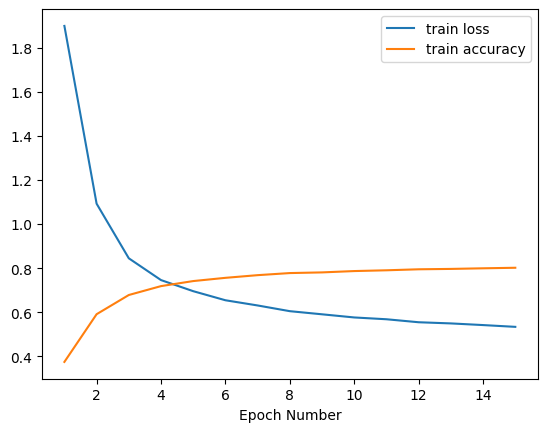

Model Result on train set :
 testing Loss : 0.5336410403251648 testing Accuracy : 0.8016861081123352
Model Result on test set :
 testing Loss : 0.538962185382843 testing Accuracy : 0.8230999708175659


In [56]:
#creating the model
model_1 = nn.Sequential(
        nn.Dropout(p=drop_rate),
        nn.LayerNorm((1, 28, 28)),
        nn.Flatten(),
        nn.Linear(784,256),
        nn.ReLU(),
        nn.Dropout(p=drop_rate),
        nn.LayerNorm((256)),
        SplitLinear(256,128),
        nn.Linear(128,10),
        nn.LogSoftmax(dim=1)).to(device)

#training and testing the dataset on the model
loss_train, acc_train = training_model(model_1, device)
loss_test, acc_test = testing_model(model_1, device)

#plot the result
plot_result(loss_train, acc_train, loss_test, acc_test, epochs)

<div dir="rtl" style="font-weight: bold; font-size: 24px;">
שאלה 2 סעיפים ה'
</div>
<div dir="rtl">
כעת נדרש מאיתנו להשתמש בשכבה DropNorm אשר יצארנו בסעיפים א'-ג'. </br>
בנוסף (בדומה לסעיף הקודם) הוספתי שיכבה linear-ReLU רגילה ואת השיכבה SplitLinear אשר ממשתי בשאלה 1. <br>
נאמן את המודל על 15 epotchs ונדפיס את הגרף והתוצאות עבור סט האימון והבדיקה.
</div>

epoch 15 / 15: 100%|██████████| 118/118 [00:08<00:00, 14.27it/s]


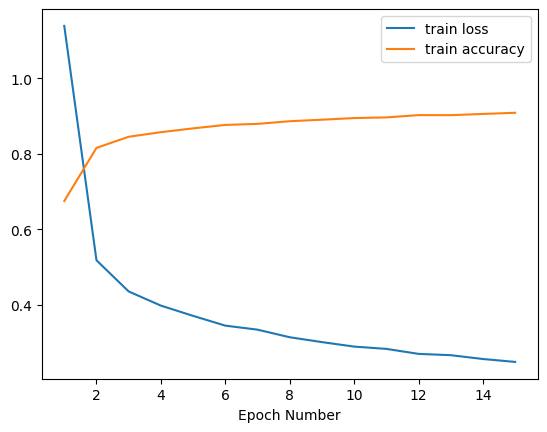

Model Result on train set :
 testing Loss : 0.2487010359764099 testing Accuracy : 0.9083355665206909
Model Result on test set :
 testing Loss : 0.35519295930862427 testing Accuracy : 0.8718000054359436


In [57]:
#creating the model
model_2 = nn.Sequential(
        DropNorm((1,28,28),drop_rate=drop_rate),
        nn.Flatten(),
        nn.Linear(784,256),
        nn.ReLU(),
        DropNorm((256)),
        SplitLinear(256,128),
        nn.Linear(128,10),
        nn.LogSoftmax(dim=1)).to(device)

#training and testing the dataset on the model
loss_train, acc_train = training_model(model_2, device)
loss_test, acc_test = testing_model(model_2, device)

#plot the result
plot_result(loss_train, acc_train, loss_test, acc_test, epochs)

<div dir="rtl" style="font-weight: bold; font-size: 24px;">
שאלה 2 סעיפים ו'
</div>
<div dir="rtl">
כאמור התוצאות שהתקבלו להלן : </br>
>דיוק : המודל הראשון הגיע לדיוק של כ~82%, המודל השני הגיע לדיוק של כ~87%<br>
>loss : המודל הראשון הגיע להפסד של כ~0.53, המודל השני הגיע להפסד של כ~0.35<br>
מהתוצאות הללו ניראה שהמודל השני בעל השיכבה DropNorm שאנו בנינו בסעיפים א'-ג' יותר טובות שכן התקבל שיפור של כ~5% דיוק ושיפור של כ~0.18 בהפסד. <br><br>
נבחן יותר מקרוב את ההבדלים בין שני המודלים. <br>
שני המודלים מעוד דומים בפעולה שהם מבצעים אך DropNorm מבצע את הנורמליזציה רק על הנוירונים שנישארו לאחר שנוירונים נפלו (drop). לעומת המודל הראשון שלא 'מודע' לכך שנוירונים נפלו (drop), ובכך נוירונים שנפלו ובעל ערך '0' לוכחים חלק בתהליך הנורמליזציה ומשפיעים על השונות ופרמטרים נוספים. <br><br>
ולכן גם בגלל התוצאה הסופית וגם בגלל הבחינה מקרוב של שני המודלים לדעתי עדיף להשתמש במודל מסעיף ה' אשר משתמש ב DropNorm. <br>
שכן הוא מדוייק יותר, בעל פחות הפסד ובעל שונות מדויקת יותר אשר אשר לוקחת בחשבות רק את הנוירונים הלא מאופסים.
</div>